In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import preprocessing

# set format
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.00,Czech Republic
1,38,6/27/2007,38.40,Czech Republic
2,47,7/2/2007,53.50,Slovakia
3,61,7/14/2007,7.00,Czech Republic
4,78,7/21/2007,55.50,Czech Republic


In [4]:
# count number of purchases for each customer
f = df.groupby('Customer ID').size().to_frame('Frequency').reset_index()
# count total spend for each customer
m = df.groupby('Customer ID')['Subtotal'].sum().to_frame('Monetary').reset_index()

In [5]:
# convert Date column to datetime format 
df['Date'] = pd.to_datetime(df['Date'])
# get highest date for each customer
r = df.groupby('Customer ID')['Date'].max().reset_index()

# function to get number of days from today
def get_days_from_today(row):
    today = pd.Timestamp(2018, 12, 23)
    result = today - row['Date']
    return result.days
    
r['Recency'] = r.apply(lambda row: get_days_from_today(row), axis=1)

In [6]:
# create rfm dataframe
rfm = f
rfm['Monetary'] = m['Monetary']
rfm['Recency'] = r['Recency']
# use ID column as index
rfm = rfm.set_index('Customer ID')

Text(0.5,0,'Frequency')

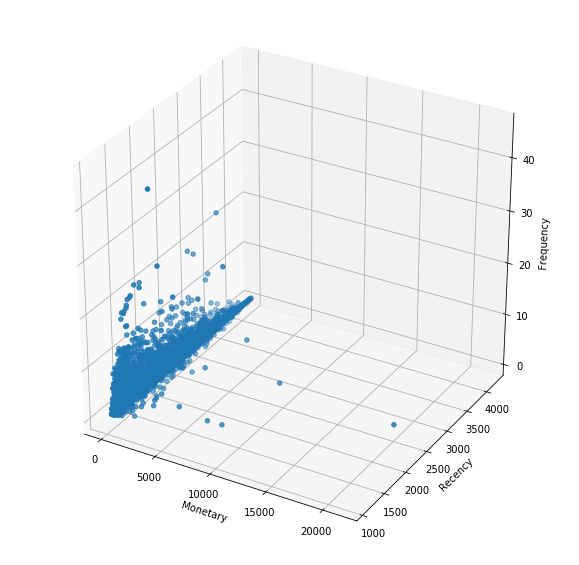

In [7]:
# 3D plot of the data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Monetary'], rfm['Recency'], rfm['Frequency'])
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

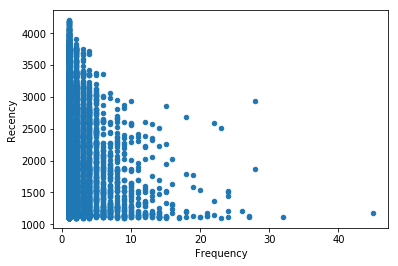

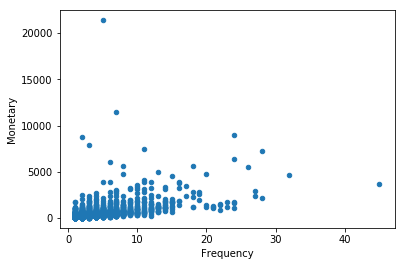

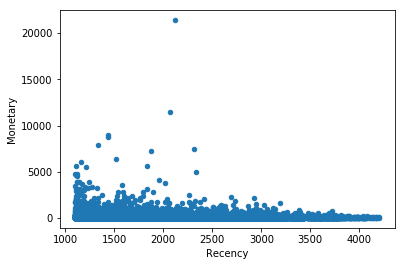

In [8]:
# we can see that the data are kinda compact with very few outliers
# but we can't directly see the groups nor number of groups 
rfm.plot(x='Frequency', y='Recency', kind='scatter')
rfm.plot(x='Frequency', y='Monetary', kind='scatter')
rfm.plot(x='Recency', y='Monetary', kind='scatter')
# 2 dimenional plots doen't provide a lot more information

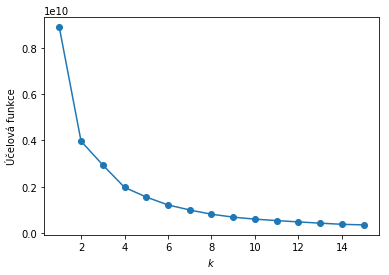

In [9]:
# let's try elbow method to determine number of clusters
ix = np.zeros(15)
iy = np.zeros(15)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state=1)
    kmeans.fit(rfm)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

# we can't see an obvious elbow, but it could be somewhere between 4 and 5

In [10]:
# if we simplify the features as binary (low monetary vs high monetary etc.)
# and we would like to get a different cluster for each combination (high monetary, high frequency, low recency etc.)
# we would need 2^3 = 8 clusters

# commercial solutions like putler.com and clevertap.com separates customers into 11 rfm segments
# they probably know why very well, but 11 clusters seems like too much for the purpose of this exercise

# we'll choose 8 as number of clusters as a compromise of all the methods we've used above 

In [11]:
kmeans = KMeans(n_clusters = 8, random_state = 1)
rfm['Cluster'] = kmeans.fit_predict(rfm)

# let's see the results
rfm.groupby('Cluster').mean()
# 0 = Average customers - low to medium frequency, low to medium monetary, medium recency
# 1 = New and potentially best customers - medium frequency, medium monetary, very low recency
# 2 = Uninteresting and lost customers - very low frequency, very low monetary, very high recency
# 3 = Best customers - very high frequency, very high monetary, low recency
# 4 = New-ish and potentially very good customers - medium frequency, low to medium monetary, low to medium recency
# 5 = Best customers that we might be loosing - high frequency, very high monetary, medium recency
# 6 = Very good customers - high frequency, high monetary, low recency
# 7 = Uninteresting and almost lost customers - low frequency, low monetary, high recency

,Frequency,Monetary,Recency
Cluster,,,
0,1.50,113.96,2425.14
1,1.85,135.59,1340.72
2,1.16,71.34,3546.38
3,15.08,5556.46,1464.04
4,1.56,114.89,1896.63
5,5.00,21392.38,2124.00
6,8.46,1371.47,1490.79
7,1.33,89.38,2967.54


In [12]:
# let's see how many customers fall into each cluster
rfm.groupby('Cluster').size()
# we can see that there are only 25 customrs in cluster 3 and only one customer in cluster 5
# does it mean we should've chosen lower number of clusters? not really because it gave us very valuable information
# cluster 5 with only one customer has separated a customer we should pay special attention to
# this customer has spend a lot of money but bought nothing recently - we should approch him to start buying again
# cluster 3 identifies 25 of our best customers that we should reward for their loyalty

Cluster
0    2881
1    3302
2    1078
3      25
4    2784
5       1
6     327
7    2431
dtype: int64

In [13]:
# drop the Cluster column for now
rfm.drop(columns='Cluster', inplace=True)
# we know that all of the features have differenct units, let's look at the scales now
rfm.describe()
# Frequency ranges from 1 to 45 (std = 2)
# Monetary ranges from 1.2 to 21392.4 (std = 407.7)
# Recency ranges from 1100 to 4203 (std = 726.5)
# the features have very different scales, so we should perform standardization

,Frequency,Monetary,Recency
count,12829.00,12829.00,12829.00
mean,1.75,155.81,2202.62
std,2.01,407.74,726.55
min,1.00,1.18,1100.00
25%,1.00,32.04,1556.00
50%,1.00,64.81,2162.00
75%,2.00,143.51,2781.00
max,45.00,21392.38,4203.00


In [14]:
# thankfully there is a StandardScaler in sklearn.prepocessing package that can do the standardization for us
scaler = preprocessing.StandardScaler()
scaled_rfm = scaler.fit_transform(rfm)
scaled_rfm = pd.DataFrame(scaled_rfm, columns=['Frequency', 'Monetary', 'Recency'])

In [15]:
# the numbers are hard to interpret now, but each feature has mean = 0 and std = 1
scaled_rfm.describe()

,Frequency,Monetary,Recency
count,12829.00,12829.00,12829.00
mean,0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-0.37,-0.38,-1.52
25%,-0.37,-0.30,-0.89
50%,-0.37,-0.22,-0.06
75%,0.13,-0.03,0.80
max,21.52,52.09,2.75


In [16]:
# use k-means on the scaled rfm dataset
rfm['Cluster'] = kmeans.fit_predict(scaled_rfm)

# let's see the results
rfm.groupby('Cluster').mean()
# unsurprisingly we get different result and it seems like the groups are easier to distinguish this time

# 0 = Uninteresting and lost customers - low frequency, low monetary, very high recency
# 1 = New customers - low frequency, low monetary, low recency
# 2 = Very good customers - very high frequency, high monetary, low recency
# 3 = Good customers - medium to high frequency, medium to high monetary, low recency
# 4 = Uninteresting customers we might be loosing - low frequency, low monetary, medium recency
# 5 = Again it's the one customer we should pay special attention to
# 6 = Good customers we might be loosing - medium frequency, medium monetary, medium recency
# 7 = Best customers - very high frequency, very high monetary, low recency

,Frequency,Monetary,Recency
Cluster,,,
0,1.20,75.16,3163.26
1,1.26,87.04,1461.46
2,14.77,1992.19,1429.94
3,7.74,834.71,1594.90
4,1.20,83.35,2302.55
5,5.00,21392.38,2124.00
6,3.70,396.14,1826.33
7,15.31,6527.08,1506.44


In [17]:
# let's see how many customers fall into each cluster
rfm.groupby('Cluster').size()
# we can see that most of the customers fall into clusters 0 1 and 4
# customers in those clusters are not too interesting, so we're happy that there are a lot of them grouped together
# again we get just one customer in the cluster 5 and 16 best customers in the cluster 7
# clusters 2, 3 and 6 containts important, but still very different, customers, so it's nice to have them separated

# overall I believe that choosing 8 as number of clusters was a good idea if we look at it from a business perspective

Cluster
0    3340
1    3901
2     108
3     374
4    4031
5       1
6    1058
7      16
dtype: int64

In [18]:
# bonus: Zkuste provést to samé s modifikovanou verzí RFM, kde
# Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", 
# Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", 
# Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

In [19]:
df['Date'].max()
# the highest date in the dataset is 19. 12. 2015
# so we'll pretend that it's 2015 today so that we don't get Frequency = 1 for every customer

Timestamp('2015-12-19 00:00:00')

In [20]:
# get max subtotal value for each customer
m = df.groupby('Customer ID')['Subtotal'].max().to_frame('Monetary').reset_index()

In [21]:
# get highest date for each customer
r = df.groupby('Customer ID')['Date'].max().reset_index()

# function to get number of months from today
def get_months_from_today(row):
    today = pd.Timestamp(2015, 12, 23)
    result = (today.year-row['Date'].year)*12+today.month-row['Date'].month
    return max(result, 1)
    
r['Recency'] = r.apply(lambda row: get_months_from_today(row), axis=1)

In [22]:
# count number of purchases for each customer in the past 12 months
f = df[df['Date'] > '2014-12-23'].groupby('Customer ID').size().to_frame('Frequency').reset_index()
# not every customer will have an entry in the Frequency dataset
# so we have to merge it on Customer ID and replace NaNs with 1
rfm = pd.merge(m, f, how='left', on='Customer ID')
rfm = rfm.fillna(1)
rfm['Recency'] = r['Recency']
# use ID column as index
rfm = rfm.set_index('Customer ID')

Text(0.5,0,'Frequency')

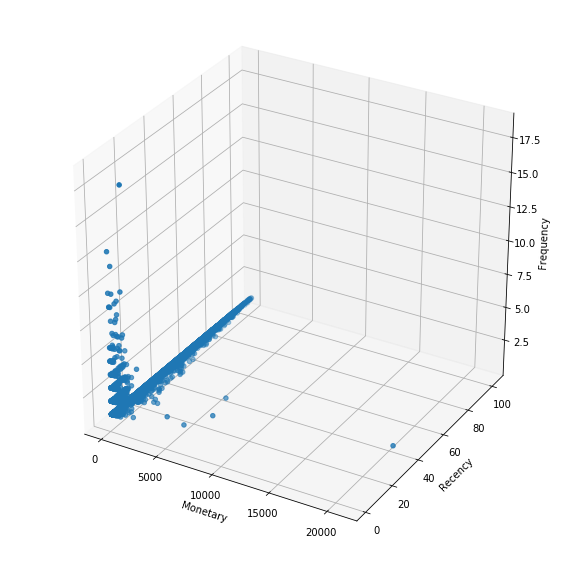

In [23]:
# 3D plot of the data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Monetary'], rfm['Recency'], rfm['Frequency'])
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

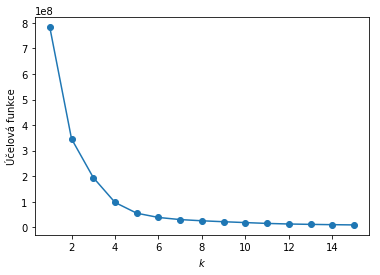

In [24]:
# let's try elbow method to determine number of clusters
ix = np.zeros(15)
iy = np.zeros(15)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state=1)
    kmeans.fit(rfm)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

# again, we can't see an obvious elbow, but it could be somewhere between 3 and 4

# data in the modified rfm dataset are less diverse (for example Frequency = 1 for 95% of the customers)
# we could use lower number of clusters, but to have a better comparison, we'll use n_clusters = 8 again

In [25]:
# standardize the data
scaler = preprocessing.StandardScaler()
scaled_rfm = scaler.fit_transform(rfm)
scaled_rfm = pd.DataFrame(scaled_rfm, columns=['Frequency', 'Monetary', 'Recency'])
# use k-meaans with n_clusters = 8
kmeans = KMeans(n_clusters = 8, random_state = 1)
rfm['Cluster'] = kmeans.fit_predict(scaled_rfm)

In [26]:
# let's see the results
display(rfm.groupby('Cluster').mean())
display(rfm.groupby('Cluster').size())

# 0 = Uninteresting and lost buyers - low monetary, low frequency, very high recency
# 1 = Uninteresting but not lost yet - low monetary, low frequency, medium recency
# 2 = Best current customers - medium monetary, high frequency, very low recency
# 3 = Very good current customers - low to medium monetary, medium frequency, low recency
# 4 = Highest buyer - highest monetary, but he hasn't bought anything for almost 3 years, get in touch with him!
# 5 = 4 very high buyers - very high monetary, low to medium frequency and medium recency
# 6 = Uninteresting and close to be lost - low monetary, low frequency, medium to high recency
# 7 = Very good buyers we might be loosing - medium to high monetary, low frequency, medium recency

,Monetary,Frequency,Recency
Cluster,,,
0,65.12,1.00,67.60
1,81.72,1.00,13.13
2,371.52,6.81,1.90
3,154.53,2.43,3.91
4,21001.05,1.00,34.00
5,6248.25,1.50,13.25
6,77.88,1.00,39.81
7,618.88,1.05,25.40


Cluster
0    3379
1    4304
2      58
3     562
4       1
5       4
6    4261
7     260
dtype: int64

In [27]:
# the groups we've got using the modified rfm dataset are very similar to the groups we've got from rfm dataset
# but the modified rfm dataset helped us identify our best current customers - groups 2 and 3